In [1]:
import matplotlib.pyplot as plt 
import scipy.misc

import numpy as np
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, Add, merge, concatenate
from keras.models import Model
from keras.utils.layer_utils import print_summary
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from keras import __version__ as kv
from scipy import __version__ as sv
from matplotlib import __version__ as mv
from numpy import __version__ as nv

print kv
print sv
print mv
print nv

Using TensorFlow backend.


2.0.5
0.19.1
2.0.0
1.13.0


In [2]:
# Local files
import utils
reload(utils)

<module 'utils' from 'utils.pyc'>

# Data

### Config

In [3]:
trained_model_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/trained_models/2.2-mph_as-best_baseline_with_distance_feature/'

In [4]:
train_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/'
valid_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/validate/50x50/'

In [5]:
input_shape = (50, 50, 1)
num_classes = 3

### Convert tif2png

Done in 1.0-mph_as_kd-baseline-simple_CNN_from_scratch.ipynb

### Add dist2land feature

In [6]:
train_crops, train_filename, train_feature, train_class, \
valid_crops, valid_filename, valid_feature, valid_class = utils.add_dist2land_experiment_crops_20170815()

In [7]:
print "training crops:", len(train_crops)
print "training features:", len(train_feature)
print "validation crops:", len(valid_filename)
print "validation features:", len(valid_feature)
print type(train_crops), type(train_crops[0]), train_crops[0].shape

training crops: 1996
training features: 1996
validation crops: 499
validation features: 499
<type 'list'> <type 'numpy.ndarray'> (50, 50)


In [8]:
# Reshape for keras format
np_train_class = np.array(train_class)
np_train_filename = np.array(train_filename)
np_train_crops = np.array(train_crops)
np_train_feature = np.array(train_feature)

np_valid_class = np.array(valid_class)
np_valid_filename = np.array(valid_filename)
np_valid_crops = np.array(valid_crops)
np_valid_feature = np.array(valid_feature)

np_train_crops = np.expand_dims(np_train_crops, axis=3)
np_train_feature = np.expand_dims(np_train_feature, axis=1)

np_valid_crops = np.expand_dims(np_valid_crops, axis=3)
np_valid_feature = np.expand_dims(np_valid_feature, axis=1)

In [9]:
print np_train_crops.shape
print np_train_feature.shape
print np_train_class.shape

print np_valid_crops.shape
print np_valid_feature.shape
print np_valid_class.shape

(1996, 50, 50, 1)
(1996, 1)
(1996, 3)
(499, 50, 50, 1)
(499, 1)
(499, 3)


# Experiments

## baseline + batchnorm with distance feature + more later dense layers + Deeper

In [11]:
p=0

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = merge([x, dist2land_input], 'concat')
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(p)(x)
x = Dense(32, activation='relu')(x)
out = Dense(num_classes, activation='softmax')(x)

model_dense_deeper = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_dense_deeper.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.

/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:460: UserWarning:

The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.



In [12]:
model_dense_deeper.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 50, 50, 1)     0                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 50, 50, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 25, 25, 32)    0           conv2d_2[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 25, 25, 64)    18496       max_pooling2d_1[0][0]            
___________________________________________________________________________________________

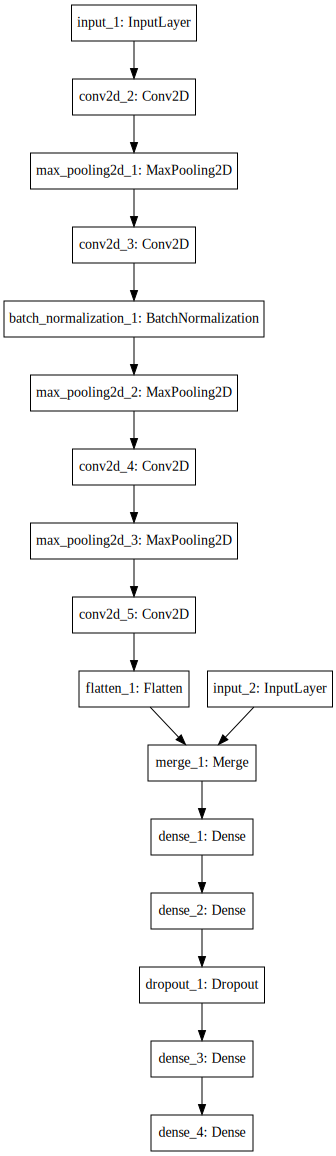

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_dense_deeper).create(prog='dot', format='svg'))

In [14]:
lr = 0.001
K.set_value(model_dense_deeper.optimizer.lr, lr)
model_dense_deeper.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/10
1996/1996 [==============================] - 28s - loss: 2.9277 - acc: 0.6528 - val_loss: 1.0653 - val_acc: 0.5752
Epoch 2/10
1996/1996 [==============================] - 28s - loss: 0.4568 - acc: 0.8357 - val_loss: 0.3583 - val_acc: 0.8677
Epoch 3/10
1996/1996 [==============================] - 28s - loss: 0.3347 - acc: 0.8813 - val_loss: 0.4380 - val_acc: 0.8257
Epoch 4/10
1996/1996 [==============================] - 28s - loss: 0.2865 - acc: 0.9053 - val_loss: 0.2117 - val_acc: 0.9339
Epoch 5/10
1996/1996 [==============================] - 29s - loss: 0.2524 - acc: 0.9168 - val_loss: 0.2348 - val_acc: 0.9259
Epoch 6/10
1996/1996 [==============================] - 29s - loss: 0.2119 - acc: 0.9319 - val_loss: 0.8356 - val_acc: 0.7615
Epoch 7/10
1996/1996 [==============================] - 29s - loss: 0.2915 - acc: 0.9233 - val_loss: 0.2281 - val_acc: 0.9118
Epoch 8/10
1996/1996 [==============================] - 29s - loss: 0.1

In [15]:
lr = 0.0001
K.set_value(model_dense_deeper.optimizer.lr, lr)
model_dense_deeper.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/10
1996/1996 [==============================] - 29s - loss: 0.0590 - acc: 0.9795 - val_loss: 0.2514 - val_acc: 0.9359
Epoch 2/10
1996/1996 [==============================] - 29s - loss: 0.0403 - acc: 0.9865 - val_loss: 0.2716 - val_acc: 0.9399
Epoch 3/10
1996/1996 [==============================] - 29s - loss: 0.0274 - acc: 0.9895 - val_loss: 0.2772 - val_acc: 0.9399
Epoch 4/10
1996/1996 [==============================] - 29s - loss: 0.0271 - acc: 0.9910 - val_loss: 0.2571 - val_acc: 0.9419
Epoch 5/10
1996/1996 [==============================] - 29s - loss: 0.0183 - acc: 0.9930 - val_loss: 0.2771 - val_acc: 0.9399
Epoch 6/10
1996/1996 [==============================] - 28s - loss: 0.0156 - acc: 0.9955 - val_loss: 0.2849 - val_acc: 0.9499
Epoch 7/10
1996/1996 [==============================] - 29s - loss: 0.0110 - acc: 0.9950 - val_loss: 0.3183 - val_acc: 0.9399
Epoch 8/10
1996/1996 [==============================] - 29s - loss: 0.0

In [16]:
lr = 0.00001
K.set_value(model_dense_deeper.optimizer.lr, lr)
model_dense_deeper.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/10
1996/1996 [==============================] - 28s - loss: 0.0039 - acc: 0.9985 - val_loss: 0.3956 - val_acc: 0.9419
Epoch 2/10
1996/1996 [==============================] - 29s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.4270 - val_acc: 0.9479
Epoch 3/10
1996/1996 [==============================] - 29s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.4295 - val_acc: 0.9479
Epoch 4/10
1996/1996 [==============================] - 29s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4381 - val_acc: 0.9419
Epoch 5/10
1996/1996 [==============================] - 29s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4450 - val_acc: 0.9439
Epoch 6/10
1996/1996 [==============================] - 29s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4522 - val_acc: 0.9479
Epoch 7/10
1996/1996 [==============================] - 29s - loss: 9.4254e-04 - acc: 1.0000 - val_loss: 0.4672 - val_acc: 0.9479
Epoch 8/10
1996/1996 [==============================] - 28s - loss:

## baseline + batchnorm with distance feature + more later dense layers + Deeper (Conv+reg)

In [17]:
p=0.5

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = merge([x, dist2land_input], 'concat')
x = Dense(128, activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(p)(x)
x = Dense(32, activation='relu')(x)
out = Dense(num_classes, activation='softmax')(x)

model_dense_deeper_conv_reg = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_dense_deeper_conv_reg.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.



In [18]:
model_dense_deeper_conv_reg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 50, 50, 1)     0                                            
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 50, 50, 32)    320         input_3[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)   (None, 25, 25, 32)    0           conv2d_6[0][0]                   
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (None, 25, 25, 64)    18496       max_pooling2d_4[0][0]            
___________________________________________________________________________________________

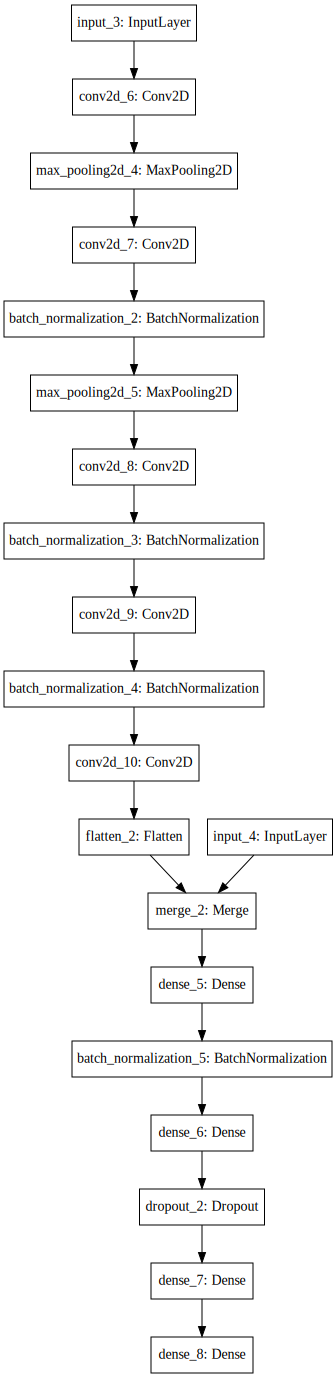

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_dense_deeper_conv_reg).create(prog='dot', format='svg'))

In [20]:
lr = 0.001
K.set_value(model_dense_deeper_conv_reg.optimizer.lr, lr)
model_dense_deeper_conv_reg.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/10
1996/1996 [==============================] - 71s - loss: 0.5239 - acc: 0.8041 - val_loss: 0.3384 - val_acc: 0.9058
Epoch 2/10
1996/1996 [==============================] - 71s - loss: 0.2987 - acc: 0.8943 - val_loss: 0.2889 - val_acc: 0.8978
Epoch 3/10
1996/1996 [==============================] - 78s - loss: 0.2083 - acc: 0.9248 - val_loss: 0.2227 - val_acc: 0.9299
Epoch 4/10
1996/1996 [==============================] - 98s - loss: 0.1768 - acc: 0.9364 - val_loss: 0.5542 - val_acc: 0.8677
Epoch 5/10
1996/1996 [==============================] - 100s - loss: 0.1497 - acc: 0.9469 - val_loss: 0.2558 - val_acc: 0.9279
Epoch 6/10
1996/1996 [==============================] - 101s - loss: 0.1238 - acc: 0.9594 - val_loss: 0.3442 - val_acc: 0.9198
Epoch 7/10
1996/1996 [==============================] - 101s - loss: 0.1173 - acc: 0.9604 - val_loss: 0.1975 - val_acc: 0.9499
Epoch 8/10
1996/1996 [==============================] - 103s - loss:

In [21]:
lr = 0.0001
K.set_value(model_dense_deeper_conv_reg.optimizer.lr, lr)
model_dense_deeper_conv_reg.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/10
1996/1996 [==============================] - 98s - loss: 0.0495 - acc: 0.9875 - val_loss: 0.2267 - val_acc: 0.9499
Epoch 2/10
1996/1996 [==============================] - 98s - loss: 0.0249 - acc: 0.9920 - val_loss: 0.2019 - val_acc: 0.9539
Epoch 3/10
1996/1996 [==============================] - 86s - loss: 0.0189 - acc: 0.9955 - val_loss: 0.1872 - val_acc: 0.9599
Epoch 4/10
1996/1996 [==============================] - 74s - loss: 0.0110 - acc: 0.9970 - val_loss: 0.2026 - val_acc: 0.9579
Epoch 5/10
1996/1996 [==============================] - 71s - loss: 0.0103 - acc: 0.9980 - val_loss: 0.2062 - val_acc: 0.9619
Epoch 6/10
1996/1996 [==============================] - 88s - loss: 0.0065 - acc: 0.9985 - val_loss: 0.2178 - val_acc: 0.9599
Epoch 7/10
1996/1996 [==============================] - 130s - loss: 0.0087 - acc: 0.9985 - val_loss: 0.2039 - val_acc: 0.9639
Epoch 8/10
1996/1996 [==============================] - 182s - loss: 0

In [22]:
lr = 0.00001
K.set_value(model_dense_deeper_conv_reg.optimizer.lr, lr)
model_dense_deeper_conv_reg.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=2,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/2
1996/1996 [==============================] - 158s - loss: 0.0021 - acc: 0.9995 - val_loss: 0.2322 - val_acc: 0.9619
Epoch 2/2
1996/1996 [==============================] - 159s - loss: 0.0048 - acc: 0.9985 - val_loss: 0.2377 - val_acc: 0.9639


In [23]:
lr = 0.00001
K.set_value(model_dense_deeper_conv_reg.optimizer.lr, lr)
model_dense_deeper_conv_reg.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=2,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/2
1996/1996 [==============================] - 97s - loss: 0.0045 - acc: 0.9985 - val_loss: 0.2405 - val_acc: 0.9639
Epoch 2/2
1996/1996 [==============================] - 98s - loss: 0.0025 - acc: 0.9995 - val_loss: 0.2427 - val_acc: 0.9639
